# ResNet 34 Model for MALDASC Drone Project
---

## Preparation Section
Same for every Notebook!

### Import Libraries

In [1]:
#Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#ResNet 34
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

torch.cuda.empty_cache()

### Dataset

#### GitHub-Data to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [4]:
%cd /content/drive/MyDrive/MALDASC/

/content/drive/MyDrive/MALDASC


In [5]:
!pwd

/content/drive/MyDrive/MALDASC


**only do once!**

In [6]:
#! git clone https://github.com/ilvkas/MALDASC_Aerial_Solar_Panels/

In [7]:
%cd /content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/
! pwd

/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels
/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels


#### Loading the Dataset (classes)

In [8]:
df_classes = pd.read_csv("_classes.csv")

#### Understanding the Dataframe

In [9]:
# show the header of the dataframe
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,1,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,1,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,1,0,1


In [10]:
# describes the datatype of all columns:
df_classes.dtypes

filename         object
 Cell             int64
 Cell-Multi       int64
 No-Anomaly       int64
 Shadowing        int64
 Unclassified     int64
dtype: object

In [11]:
# provide an overview of the different column data types and missing values:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       161 non-null    object
 1    Cell          161 non-null    int64 
 2    Cell-Multi    161 non-null    int64 
 3    No-Anomaly    161 non-null    int64 
 4    Shadowing     161 non-null    int64 
 5    Unclassified  161 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 7.7+ KB


In [12]:
# display number of missing values per column:
df_classes.isna().sum()

filename         0
 Cell            0
 Cell-Multi      0
 No-Anomaly      0
 Shadowing       0
 Unclassified    0
dtype: int64

#### Classes explained

- `Cell`: Hot spot occurred in a single cell with square geometry
- `Cell-Multi`: Hot spot occurred in multiple cells with a square geometry in each cell
- `No-Anomaly`: Nominal solar module
- `Shadowing`: Sunlight obstructed by vegetation, man-made structures, or adjacent rows.
- `Unclassified`: unknown

#### Data Cleaning

##### Problem 1: Column names
All the labels have a space before their name. Instead of `Cell` it is written as `_Cell`.

In [13]:
# Before renaming the columns
print(df_classes.columns)

Index(['filename', ' Cell', ' Cell-Multi', ' No-Anomaly', ' Shadowing',
       ' Unclassified'],
      dtype='object')


In [14]:
df_classes.rename(columns = {'filename':'filename', ' Cell':'Cell', ' Cell-Multi':'Cell-Multi', ' No-Anomaly':'No-Anomaly', ' Shadowing':'Shadowing', ' Unclassified':'Unclassified'}, inplace = True)

In [15]:
# After renaming the columns
print(df_classes.columns)

Index(['filename', 'Cell', 'Cell-Multi', 'No-Anomaly', 'Shadowing',
       'Unclassified'],
      dtype='object')


##### Problem 2: image classification vs object detection
We have found that some entries contain `Cell`, `Cell-Multi` and `No-Anomaly`. Since we are working in a `image classification` problem, not in `object detection` there is no benefit gained from having `Cell` and `No-Anomaly` classifications for on the same image.<br/>
Therefore we will remove any `1` in `No-Anomaly` if we find a `1` in either `Cell` or `Cell-Multi`.

In [16]:
# count the numbers of No-Anomaly
count = df_classes[df_classes['No-Anomaly'] == 1].shape[0]
print(count)

97


In [17]:
# check examples to see if if we have Cell and No-Anomaly in entries
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,1,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,1,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,1,0,1


We can see that Entries 0, 3 & 4 in the `.head()` function have a 1 in `No-Anomaly` when it should have been a 0. 

In [18]:
# In this line of code, (df_classes['Cell'] == 1) | (df_classes['Cell-Multi'] == 1) will create a boolean mask where each row is True if 'Cell' or 'Cell-Multi' is 1 in that row, and False otherwise.
# Then df_classes.loc[mask, 'No-Anomaly'] = 0 will set the 'No-Anomaly' column to 0 where the mask is True.
df_classes.loc[(df_classes['Cell'] == 1) | (df_classes['Cell-Multi'] == 1), 'No-Anomaly'] = 0

In [19]:
df_classes.head()

,filename,Cell,Cell-Multi,No-Anomaly,Shadowing,Unclassified
0,IRX_2862_jpg.rf.00fe2e51ae6f26aea2fa97e3fab5ca...,1,0,0,0,1
1,DJI_20220217143305_0097_T_JPG.rf.0aacb82e2cf11...,0,0,0,0,0
2,IRX_2670_jpg.rf.3cf5907b38c7ab3072d5c8ef493779...,0,0,0,0,0
3,IRX_3012_jpg.rf.2d4a8e1d09f36ba29c7739a1e933ab...,1,1,0,0,1
4,IRX_2904_jpg.rf.0dd6742436306ac7e51f8c33e38f7a...,1,0,0,0,1


In [20]:
# count after cleaning
count = df_classes[df_classes['No-Anomaly'] == 1].shape[0]
print(count)

15


In [21]:
# TODO

#### Data Split, Image Resize & Class Balance

In [22]:
# You should create a composite of transformations that are going to be applied on the training/test images.
# As the resolution of the images varies, all images have to be resized to 224x224 pixels. Next,
# you should normalise the image pixels to the [0,1] and, afterwards, normalise the data to
# zero-mean and standard-deviation using the pre-defined values given by (mean_values, std_values).
# Hint: Have a look at transforms.Compose(), transforms.ToTensor() and related functions.

import os
from PIL import Image
import numpy as np

# Path to the directory containing the images
image_dir = '/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images/'

# List all image file names in the directory
image_files = os.listdir(image_dir)

# Initialize an empty list to store the resized and normalized images
resized_images = []

# Loop through each image file
for image_file in image_files:
    # Open the image using PIL
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)

    # Resize the image to 224x224 pixels
    resized_image = image.resize((224, 224))

    # Convert the image to a numpy array
    resized_array = np.array(resized_image)

    # Normalize the image to the range [0, 1]
    normalized_image = resized_array / 255.0

    # Append the normalized image to the list
    resized_images.append(normalized_image)

# Convert the list of images to a numpy array
resized_images = np.array(resized_images)

# Calculate the mean and standard deviation of the images
mean = np.mean(resized_images)
std = np.std(resized_images)

print('Mean:', mean)
print('Standard Deviation:', std)


Mean: 0.4018914352749372
Standard Deviation: 0.30288855966844513


In [23]:
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x512 at 0x7F93D1A97CA0>


In [24]:
print(image_path)

/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images/IRX_3180_jpg.rf.927b038310a476603846b5c52913a76d.jpg


### GPU

In [25]:
plt.ion() 

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


# ResNet-101
For every model do not forget:
- Model definition
- Loss function
- Optimiser
- Scheduler
- Model Training
 - Training vs Validation Loss
 - Tr vs Val Acc
- Model Evaluation
 - Confusion Matrix

In [26]:
# Define hyperparameters
learning_rate = 1e-4
weight_decay = 1e-5
batch_size = 16
num_epochs = 100

In [27]:
# Define Class
class MultiLabelDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.labels_frame = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = self.labels_frame.iloc[idx, 0]  # Assuming filename is in the first column
        image = Image.open(f'{self.img_dir}/{img_name}')
        labels = self.labels_frame.iloc[idx, 1:].values.astype(float)
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [28]:
# Transform data into Tensor that has range [0,1]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [29]:
# paths
img_dir = '/content/drive/MyDrive/MALDASC/MALDASC_Aerial_Solar_Panels/images'
csv_file = df_classes

dataset = MultiLabelDataset(df_classes, img_dir=img_dir, transform=transform)

In [30]:
# Split Data into Train, Val & Test V1.0 (random split)
# Define the proportions
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Make sure the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

# Calculate the number of samples to include in each split
total = len(dataset)
train_size = int(train_ratio * total)
val_size = int(val_ratio * total)
test_size = total - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [31]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [32]:
# Use ResNet-101
model = torchvision.models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Modify the last layer
num_features = model.fc.in_features
num_classes = len(dataset.labels_frame.columns) -1 # subtract one for index column
model.fc = torch.nn.Linear(num_features, num_classes)

In [34]:
# Define a loss function and an optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [35]:
# Training and Validation Loop
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists for plotting
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    # Training
    model.train()  # set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()  # set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_loss_list.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/100, Train Loss: 0.7055, Validation Loss: 0.6911
Epoch 2/100, Train Loss: 0.7016, Validation Loss: 0.6849
Epoch 3/100, Train Loss: 0.6981, Validation Loss: 0.6830
Epoch 4/100, Train Loss: 0.6936, Validation Loss: 0.6819
Epoch 5/100, Train Loss: 0.6878, Validation Loss: 0.6803
Epoch 6/100, Train Loss: 0.6841, Validation Loss: 0.6775
Epoch 7/100, Train Loss: 0.6796, Validation Loss: 0.6737
Epoch 8/100, Train Loss: 0.6733, Validation Loss: 0.6694
Epoch 9/100, Train Loss: 0.6729, Validation Loss: 0.6660
Epoch 10/100, Train Loss: 0.6670, Validation Loss: 0.6614
Epoch 11/100, Train Loss: 0.6624, Validation Loss: 0.6583
Epoch 12/100, Train Loss: 0.6598, Validation Loss: 0.6562
Epoch 13/100, Train Loss: 0.6544, Validation Loss: 0.6524
Epoch 14/100, Train Loss: 0.6547, Validation Loss: 0.6495
Epoch 15/100, Train Loss: 0.6511, Validation Loss: 0.6470
Epoch 16/100, Train Loss: 0.6439, Validation Loss: 0.6438
Epoch 17/100, Train Loss: 0.6417, Validation Loss: 0.6418
Epoch 18/100, Train Los

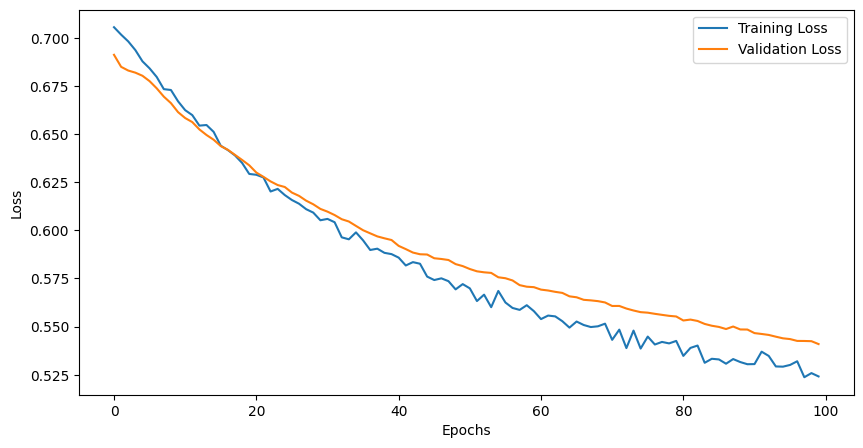

In [36]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.size(0)
        correct += accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy(), normalize=False)

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 36.0 %


In [38]:
# Function to show an image
def imshow(img, ax=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [39]:
# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next(dataiter), not dataiter.next()

In [40]:
# Move images to the configured device
images = images.to(device)

# Get predicted labels
outputs = model(images)
predicted_probs = torch.sigmoid(outputs)  # Apply sigmoid but not the binary threshold

# Move tensors back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted_labels = predicted.cpu()

# Convert predicted probabilities to binary class memberships
predicted_binary = (predicted_probs > 0.5).int()

IndexError: ignored

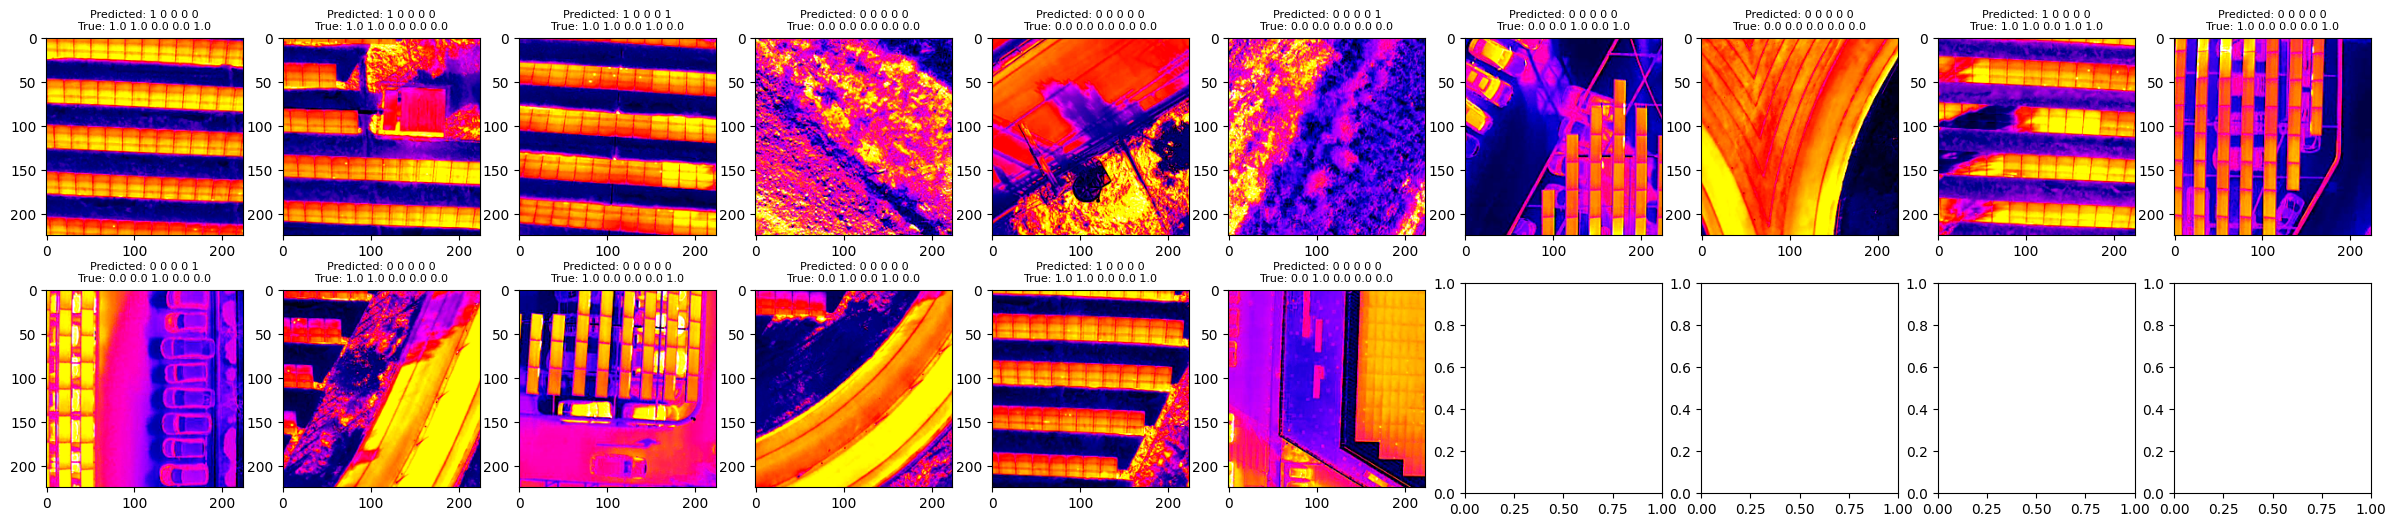

In [41]:
# Plot images with predicted and true labels
fig, axs = plt.subplots(2, 20//2, figsize=(30, 6))
for idx, ax in enumerate(axs.flatten()):  # axs.flatten() returns a 1D array of the subplots
    if idx >= 20:  # Change the number depending on how many images you want to display
        break
    imshow(images[idx], ax=ax)
    predicted = predicted_binary[idx].cpu().numpy().tolist()
    true = labels[idx].numpy().tolist()
    ax.set_title(f"Predicted: {' '.join(map(str, predicted))}\nTrue: {' '.join(map(str, true))}", fontsize=8)
plt.tight_layout()
plt.show()